## calculating the effects of CF uncertainty on an ecoinvent activity

This notebook exemplifies the calculation of the effects of CF uncertainty on an LCA calculation. To avoid spurious correlations, we use the same **A** and **B** matrices within each iteration for both cases. 

In paralel it also keeps track during the calculation of the elements within the characterized inventory matrix (calculated only considering **C** uncertainty) with the highest variability. This should give an idea of which flows are responsible of most of the uncertainty.

In [1]:
import brightway2 as bw
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def cf_uncertainty_contribution(activity,method_deterministic,method_uncertain,iterations=100,nmax_contributors=10):
    """"""
    deterministic_lca = bw.LCA({activity:1},method_deterministic)
    mc = bw.MonteCarloLCA({activity:1},method_uncertain)
    
    
    # inizialize indicators
    deterministic_lca.lci()
    deterministic_lca.lcia()
    next(mc)
    minimum = (mc.characterization_matrix).dot(deterministic_lca.inventory).data
    maximum = (mc.characterization_matrix).dot(deterministic_lca.inventory).data
    
    rev_actdict,rev_proddict,rev_biodict = mc.reverse_dict()
    
    #just in case
    assert mc.biosphere_dict==deterministic_lca.biosphere_dict
    assert mc.product_dict == deterministic_lca.product_dict
    
    results =  []
    for _ in range(iterations):
        next(mc)
        
        # contribution to uncertainty
        characterised_inventory = (mc.characterization_matrix).dot(deterministic_lca.inventory)
        minimum = np.minimum(minimum,characterised_inventory.data)
        maximum = np.maximum(maximum,characterised_inventory.data)
        
        # effects of uncertainty in CF
        score_deterministic_c = deterministic_lca.characterization_matrix.dot(mc.inventory).sum()
        score_uncertain_c = mc.score
        results.append((score_deterministic_c,score_uncertain_c))
    
    rng = maximum - minimum
    maxindices = list(reversed(np.argsort(rng)))
    
    top_contributors=[]
    for i,maxi in enumerate(maxindices):
        
        maxrow = rev_biodict[mc.characterized_inventory.tocoo().row[maxi]]
        maxcol = rev_actdict[mc.characterized_inventory.tocoo().col[maxi]]
        value = rng[maxi]
        top_contributors.append((maxrow,maxcol,value))
        
        if i > nmax_contributors:
            break
            
    return (results,top_contributors)

In [3]:
bw.projects.set_current('uncertain archetype III')

In [4]:
resp_inorg_uniform = ('ILCD 2.0 2018 midpoint','human health','respiratory effects, inorganics','archetype uncertainty','uniform')

In [5]:
resp_inorg_deterministic = ('ILCD 2.0 2018 midpoint', 'human health', 'respiratory effects, inorganics')

In [6]:
train_de=[act for act in bw.Database('ei_36con') if (act['name']=='transport, passenger train') and (act['location']=='DE')][0]

In [7]:
%time results,train_cf_contribution = cf_uncertainty_contribution(train_de,resp_inorg_deterministic,resp_inorg_uniform,iterations=2000)

Wall time: 5min 47s


flows and corresponding activities that introduce the largest uncertainty in the result

In [8]:
for irow,icol,value in train_cf_contribution:
    activity = bw.get_activity(icol)
    bioflow = bw.get_activity(irow)
    
    print(f"{activity['name']} --- {bioflow['name']} ---{value:.2e}")
    

transport, freight, lorry >32 metric ton, EURO5 --- Particulates, < 2.5 um ---8.53e-10
transport, freight, light commercial vehicle, EURO1 --- Nitrogen oxides ---2.16e-10
sulfate pulp production, from hardwood, bleached --- Particulates, < 2.5 um ---1.19e-10
machine operation, diesel, >= 74.57 kW, high load factor --- Particulates, < 2.5 um ---8.10e-11
lorry production, 28 metric ton --- Particulates, < 2.5 um ---3.24e-11
containerboard production, fluting medium, semichemical --- Particulates, < 2.5 um ---3.04e-11
transport, freight, lorry with refrigeration machine, 7.5-16 ton, EURO5, R134a refrigerant, freezing --- Sulfur dioxide ---2.20e-11
welding, gas, steel --- Particulates, < 2.5 um ---2.16e-11
transport, freight train, electricity --- Particulates, < 2.5 um ---1.77e-11
lorry production, 16 metric ton --- Particulates, < 2.5 um ---1.68e-11
water pump operation, diesel --- Sulfur dioxide ---1.47e-11
steel production, electric, low-alloyed --- Particulates, < 2.5 um ---1.32e-11


In [9]:
results_df = pd.DataFrame(results,columns=['deterministic_C','uncertain_C'])

In [10]:
results_df_long = results_df.stack().to_frame('score')

In [11]:
results_df_long.index.names = ['iteration','case']

In [12]:
deterministic = bw.LCA({train_de:1},resp_inorg_deterministic)
deterministic.lci()
deterministic.lcia()
deterministic.score

2.3417703632272222e-09

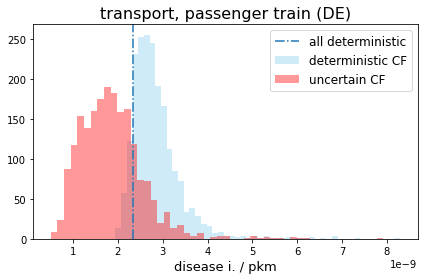

In [76]:
sns.distplot( results_df['deterministic_C'] , color="skyblue", label="deterministic CF",kde=False)
sns.distplot( results_df['uncertain_C'] , color="red", label="uncertain CF",kde=False)
plt.title('transport, passenger train (DE)',fontsize=16)
plt.axvline(deterministic.score,ls="-.",label='all deterministic')

#interquartile range
#plt.axvline(results_df.deterministic_C.quantile(0.25),color="skyblue",alpha=0.3,label='IQR')
#plt.axvline(results_df.deterministic_C.quantile(0.75),color="skyblue",alpha=0.3)
#plt.axvline(results_df.uncertain_C.quantile(0.25),color="red",alpha=0.3,label='IQR')
#plt.axvline(results_df.uncertain_C.quantile(0.75),color="red",alpha=0.3)

plt.legend(fontsize=12);
plt.xlabel('disease i. / pkm',fontsize=13)

plt.tight_layout()
plt.savefig('train_results_for_presentation.png',dpi=300)

### procedure

calculate the CF

```python
# returns a list of tuples with the CF as defined in brightway
my_new_cf = cf_add_uncertainty(('ReCiPe Midpoint (E) V1.13', 'marine eutrophication', 'MEP'),
                                uncertainty_type=4) # -> uniform
```

store the new Impact Assessment method via the normal procedure

```python
my_new_method_name = ('marine eutrophication','with uncertainty')
metadata={'description':'awesome method','unit':'kg N-eq'}

my_new_method = bw.Method(my_new_method_name)
my_new_method.register(**metadata)
my_new_method.write(my_new_cf)
```

ready to use!

```python
# use it!
random_activity = bw.Database('ei_36con').random()
mc = bw.MonteCarloLCA({random_activity:1},
                 method=('marine eutrophication','with uncertainty'))
```

## how different they are ?

In [14]:
results_df

,deterministic_C,uncertain_C
0,2.657870e-09,1.905526e-09
1,3.379641e-09,2.013112e-09
2,2.792531e-09,1.921698e-09
3,2.814291e-09,1.406717e-09
4,2.533271e-09,1.289605e-09
...,...,...
1995,3.032880e-09,2.258590e-09
1996,2.835701e-09,1.597535e-09
1997,3.293699e-09,2.407170e-09
1998,3.294698e-09,1.569744e-09


In [15]:
results_df['diff'] = results_df.deterministic_C - results_df.uncertain_C

<AxesSubplot:>

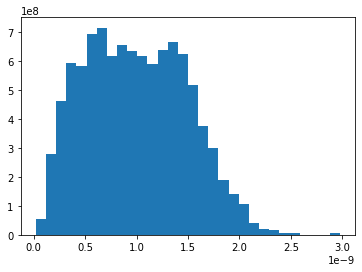

In [16]:
results_df['diff'].hist(grid=False,bins=30,density=True)

In [18]:
results_df = results_df.sort_values(by='diff')

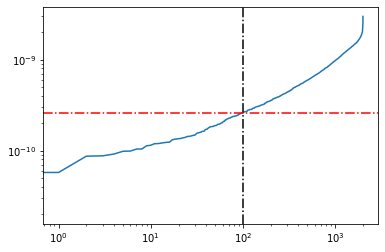

In [34]:
results_df['diff'].reset_index(drop=True).plot();
plt.axvline(len(results_df)*0.05,color='k',ls='-.')
plt.axhline(results_df['diff'].quantile(0.05),color='r',ls='-.')
plt.xscale('log')
plt.yscale('log')

In [49]:
q10 = (results_df['diff']/results_df.deterministic_C).quantile(0.1)

In [51]:
f"results are {q10:.1%} lower for 90% of the iterations when we consider CF uncertainty"

'results are 12.5% lower for 90% of the iterations when we consider CF uncertainty'

In [58]:
f"standard deviation {results_df.uncertain_C.std()/results_df.deterministic_C.std():.1%} the original standard deviation"

'standard deviation 122.1% the original standard deviation'

5.769335417262094e-10